In [1]:
import pandas as pd

In [2]:
import os
print(os.getcwd())

c:\Users\akans\OneDrive\Desktop\ML


In [3]:
train = pd.read_csv("tour_logs_train.csv")
test = pd.read_csv("tour_logs_test_input.csv")

In [4]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gig_ID                 2000 non-null   object 
 1   Venue_ID               2000 non-null   object 
 2   Show_DateTime          2000 non-null   object 
 3   Day_of_Week            2000 non-null   int64  
 4   Volume_Level           1819 non-null   float64
 5   Ticket_Price           2000 non-null   object 
 6   Crowd_Size             1960 non-null   float64
 7   Opener_Rating          2000 non-null   int64  
 8   Weather                2000 non-null   object 
 9   Moon_Phase             2000 non-null   object 
 10  Band_Outfit            2000 non-null   object 
 11  Merch_Sales_Post_Show  2000 non-null   int64  
 12  Crowd_Energy           2000 non-null   float64
dtypes: float64(3), int64(3), object(7)
memory usage: 203.3+ KB


In [5]:
train.describe()

,Day_of_Week,Volume_Level,Crowd_Size,Opener_Rating,Merch_Sales_Post_Show,Crowd_Energy
count,2000.000000,1819.000000,1960.000000,2000.00000,2000.000000,2000.000000
mean,3.006000,5.637163,610.836735,3.01700,797.040500,55.126035
std,2.024849,5.508995,1941.634319,1.40844,323.222699,47.384777
min,0.000000,-5.000000,-100.000000,1.00000,0.000000,-10.000000
25%,1.000000,3.000000,425.000000,2.00000,626.750000,43.150000
50%,3.000000,5.000000,530.000000,3.00000,825.000000,55.515000
75%,5.000000,8.000000,648.000000,4.00000,1019.000000,67.447500
max,6.000000,99.000000,50000.000000,5.00000,1529.000000,999.000000


In [6]:
train.dtypes

Gig_ID                    object
Venue_ID                  object
Show_DateTime             object
Day_of_Week                int64
Volume_Level             float64
Ticket_Price              object
Crowd_Size               float64
Opener_Rating              int64
Weather                   object
Moon_Phase                object
Band_Outfit               object
Merch_Sales_Post_Show      int64
Crowd_Energy             float64
dtype: object

Numerical features are Day_of_Week, Volume_Level, Crowd_Size, Opener_Rating, Merch_Sales_Post_Show
Category features are Venue_ID, Weather, Moon_Phase, Band_Outfit
Show_DateTime needs conversion to proper format
Ticket_Price is likely in different currencies and needs normalization

Target variable is Crowd_Energy; continuous scale from 0-100

Crowd_Size is assumed to be pre show attendance and not post show

###### DATA CLEANING

Columns requiring preprocessing: Show_DateTime, Ticket_Price
Need to handle missing values in Volume_Level and Crowd_Size

In [7]:
train = train.drop(columns=['Merch_Sales_Post_Show'])
test = test.drop(columns=['Merch_Sales_Post_Show'])

Column Merch_Sales_Post_Show need to be removed as it contains post event info that might lead to data leakage as this info is not available during prediction time

In [8]:
train['Show_DateTime'] = pd.to_datetime(train['Show_DateTime'], errors='coerce')
test['Show_DateTime'] = pd.to_datetime(test['Show_DateTime'], errors='coerce')

In [9]:
train = train.drop(columns=['Gig_ID'])
test = test.drop(columns=['Gig_ID'])

Gig_ID is a unique identifier and excluded from model training

In [10]:
train['Volume_Level'].fillna(train['Volume_Level'].median(), inplace = True)
train['Crowd_Size'].fillna(train['Crowd_Size'].median(), inplace = True)
test['Volume_Level'].fillna(test['Volume_Level'].median(), inplace = True)
test['Crowd_Size'].fillna(test['Crowd_Size'].median(), inplace = True)

Ticket prices normalized by extracting numeric values from string, handling multiple currencies and converting all to USD

In [11]:
def normalize_price(price):
    if pd.isna(price):
        return None
    if price.lower()== "free":
        return 0.0
    price = price.replace("â‚¬", "€")
    if "€" in price:
        currency = "EUR"
        price = price.replace("€", "")
    elif "£" in price:
        currency = "GBP"
        price = price.replace("£", "")
    elif "USD" in price:
        currency = "USD"
        price = price.replace("USD", "")
    elif "$" in price:
        currency = "USD"
        price = price.replace("$", "")
    else:
        currency = "USD"
    try:
        value = float(price)
    except:
        return None
    if currency == "EUR":
        value *= 1.09
    elif currency == "GBP":
        value *= 1.27
    return value

In [12]:
train['Ticket_Price'] = train['Ticket_Price'].apply(normalize_price)
test['Ticket_Price'] = test['Ticket_Price'].apply(normalize_price)

In [13]:
train['Ticket_Price'].head(10)
train['Ticket_Price'].describe()

count    1954.000000
mean       51.664690
std        20.272414
min         0.000000
25%        38.235000
50%        51.805000
75%        64.737500
max       120.000000
Name: Ticket_Price, dtype: float64

Total number of records were 2000 but the count for Ticket_Price is 1954 this might be because some price strings were too malformed to be converted or had unexpected text that the function returned None for those. Quite normal in datasets. These missing values are replaced by the median of Ticket_Prices

In [14]:
median_price = train['Ticket_Price'].median()
train['Ticket_Price'].fillna(median_price, inplace = True)
test['Ticket_Price'].fillna(median_price, inplace = True)

In [15]:
train['Ticket_Price'].describe()

count    2000.000000
mean       51.667917
std        20.037818
min         0.000000
25%        38.622500
50%        51.805000
75%        64.372500
max       120.000000
Name: Ticket_Price, dtype: float64

###### EDA

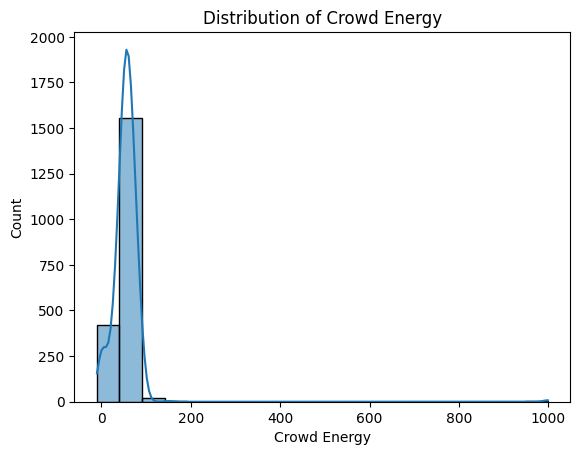

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(train['Crowd_Energy'], bins=20, kde=True)
plt.xlabel("Crowd Energy")
plt.ylabel("Count")
plt.title("Distribution of Crowd Energy")
plt.show()

In [17]:
train[train['Crowd_Energy']>100]

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
591,V_Delta,2024-05-27 23:00:00,0,11.0,24.0200,347.0,1,Clear,Waning Gibbous,Leather,999.0
863,V_Alpha,2024-07-11 19:00:00,3,5.0,76.8200,519.0,5,Stormy,Waxing Crescent,Spandex,999.0
1110,V_Alpha,2024-05-28 20:00:00,1,5.0,36.4400,543.0,3,Cloudy,Waning Gibbous,Leather,999.0
1364,V_Gamma,2024-06-16 23:00:00,6,8.0,80.9652,594.0,1,Cloudy,First Quarter,Denim,999.0
1448,V_Gamma,2024-04-09 18:00:00,1,5.0,84.8020,532.0,5,Clear,New Moon,Leather,150.0
1998,V_Beta,NaT,1,9.0,53.3700,503.0,1,Rainy,Waning Gibbous,Leather,150.0


Crowd energy must be between 0 and 100. Need to remove these anomalic values. Since these are wrong logs, we do not replace them and just simply remove

In [18]:
train = train[(train['Crowd_Energy'] >= 0) & (train['Crowd_Energy'] <= 100)]

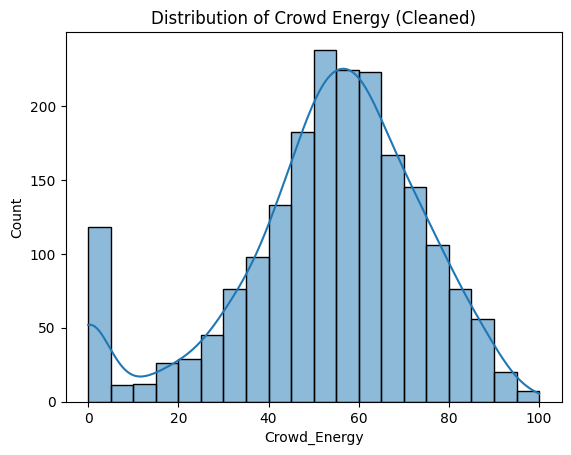

In [19]:
sns.histplot(train['Crowd_Energy'], bins=20, kde=True)
plt.title("Distribution of Crowd Energy (Cleaned)")
plt.show()

Crowd energy values broadly distributed with most venues showing moderate to high energy level

For boxplots:
Middle line in each box represents the median crowd energy

Box is the IQR

Dots are outliers

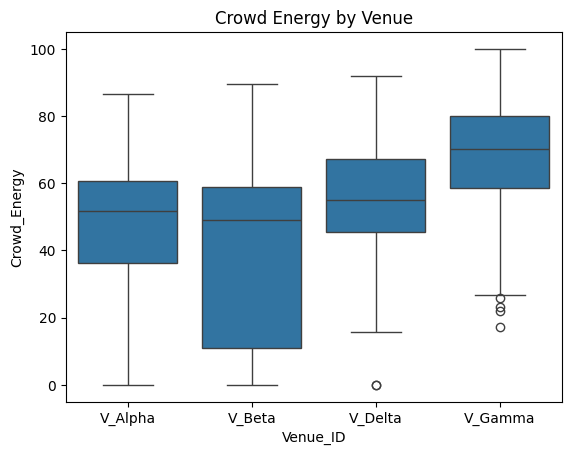

In [20]:
sns.boxplot(x='Venue_ID', y='Crowd_Energy', data=train)
plt.title("Crowd Energy by Venue")
plt.show()

V_Gamma:

Highest median crowd energy

Tighter IQR (more consistent high energy)

Few low outliers (generally good performances)


Likely best performing venue

V_Delta:

Moderate-high median

One extremely low outlier

Broader IQM (more varying audience response)

V_Beta:

Lowest median

Largest variablility (Broadest IQM)

Many low values 

Weakest venue on average

V_Alpha:

Medium median

Broad IQM (incosistent crowd response)

Energy can be very low or very high

Crowd energy shows a strong relation to particular venues

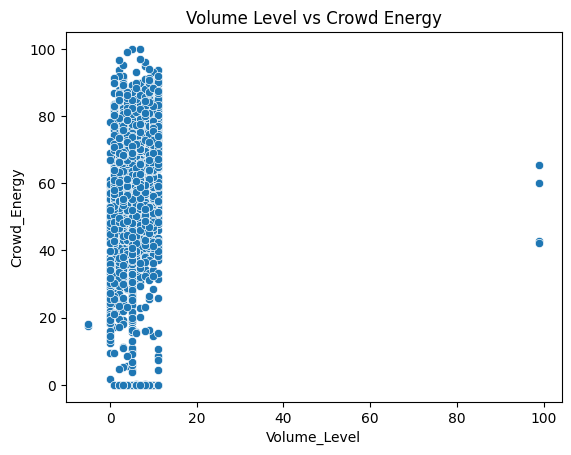

In [21]:
sns.scatterplot(x='Volume_Level', y='Crowd_Energy', data=train)
plt.title("Volume Level vs Crowd Energy")
plt.show()

Small number of extremely high volume values retained as they may indicate high intensity performances

Weak-moderate positive relationship between volume level and crowd energy. Higher volume corresponds to more energy. But significant variablility suggest volume alone cannot predict crowd energy

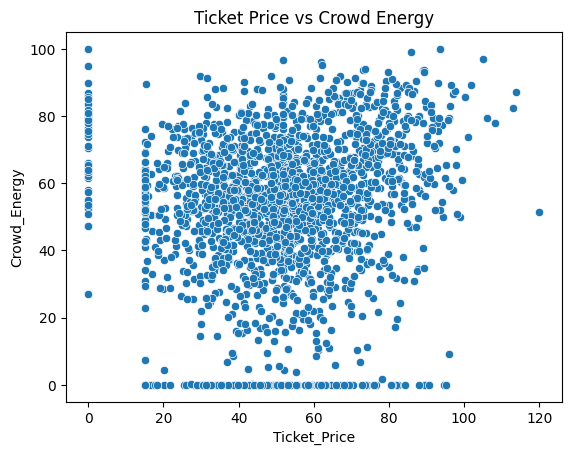

In [22]:
sns.scatterplot(x='Ticket_Price', y='Crowd_Energy', data=train)
plt.title("Ticket Price vs Crowd Energy")
plt.show()

Weak positive relationship between ticket prices and crowd energy. Higher prices gigs have slightly higher energy. Large variance shows ticket prices alone is a poor indicator of energy levels 

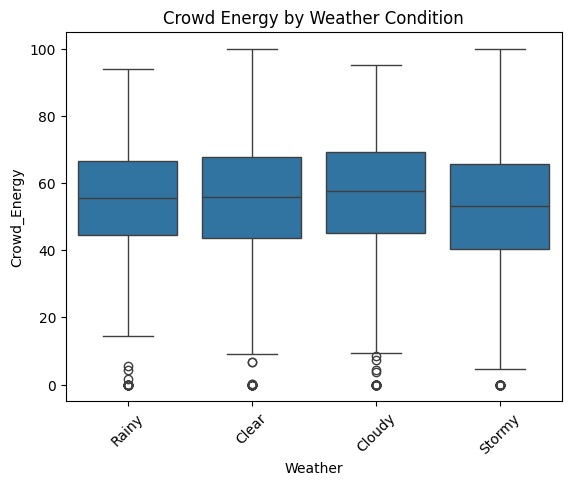

In [23]:
sns.boxplot(x='Weather', y='Crowd_Energy', data=train)
plt.xticks(rotation=45)
plt.title("Crowd Energy by Weather Condition")
plt.show()

Plot indicates crowd energy is almost similar across all weather conditions. Clear and cloudy conditions have a slightly higher median. Low energy outliers are more frequent in rainy and cloudy conditions, most likely for open venues. Substantial overlap shows that weather conditions alone is not a strong predictor for crowd energy

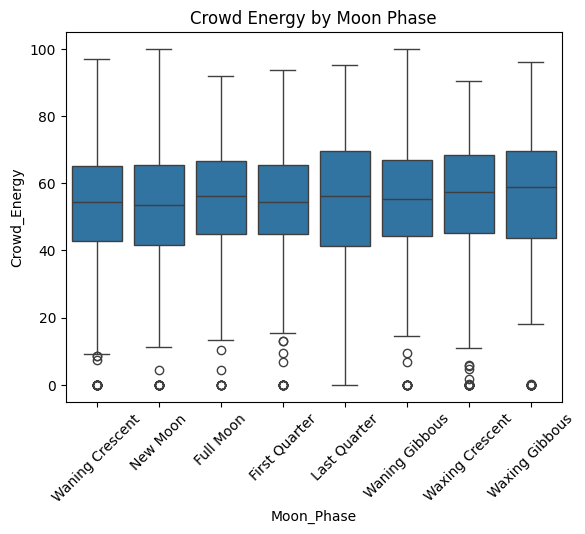

In [24]:
sns.boxplot(x='Moon_Phase', y='Crowd_Energy', data=train)
plt.xticks(rotation=45)
plt.title("Crowd Energy by Moon Phase")
plt.show()

Crowd energy is broadly similar across all moon phases. While there are minor differences in the median values, moon phases do not strongly influence crowd energy. 

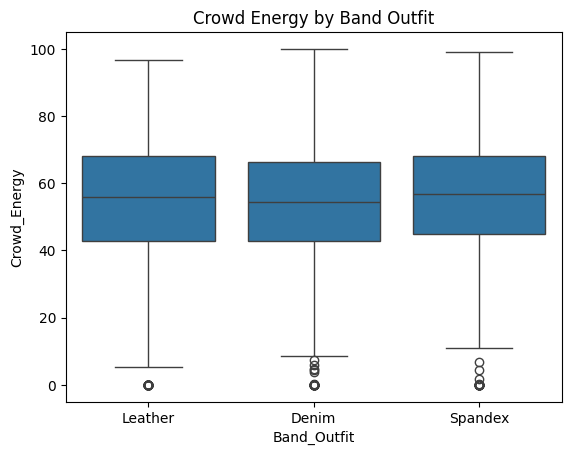

In [25]:
sns.boxplot(x='Band_Outfit', y='Crowd_Energy', data=train)
plt.title("Crowd Energy by Band Outfit")
plt.show()

Overall crowd energy is similar for the different band outfits. Although there are some differences in the number of outliers for the different outfits, it can be concluded that band outfits is not the strongest predictor for crowd energy

###### FEATURE ENGINEERING

In [26]:
X = train.drop(columns=['Crowd_Energy'])
y = train['Crowd_Energy']

In [27]:
for df in [train,test]:
    df['show_hour'] = df['Show_DateTime'].dt.hour
    df['show_day'] = df['Show_DateTime'].dt.day
    df['show_month'] = df['Show_DateTime'].dt.month
    df['is_weekend'] = df['Day_of_Week'].isin([5,6]).astype(int)

In [28]:
X = X.drop(columns= 'Show_DateTime')
test = test.drop(columns= 'Show_DateTime')

In [29]:
categorical_cols = X.select_dtypes(include= "object").columns.tolist()
numerical_cols = X.select_dtypes(exclude= "object").columns.tolist()

In [30]:
categorical_cols, numerical_cols

(['Venue_ID', 'Weather', 'Moon_Phase', 'Band_Outfit'],
 ['Day_of_Week',
  'Volume_Level',
  'Ticket_Price',
  'Crowd_Size',
  'Opener_Rating'])

Feature scaling not applied as tree based models are used

###### MODEL TRAINING AND EVALUATION

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
preprocessor = ColumnTransformer(
    transformers= [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ]
)

In [32]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(
    n_estimators= 200,
    random_state= 42
)

In [33]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

In [35]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [36]:
test_predictions = pipeline.predict(test)

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = pipeline.predict(X_val)
mean_error = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mean_error, r2

(13.040372556390983, 0.3227536981681388)

Random Forest model, using default values, achieves a mean absolute error of approximately 13.04 indicating that predicted values differ from actual values by about 13.04 energy units on an average. R^2 score is around 0.322, this mean about 32.2% of the variance in crowds energy is explained by engineered features.

###### HYPERPARAMETER TUNING

In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [10, 15, None]
}
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)
grid.best_params_

{'model__max_depth': 10, 'model__n_estimators': 500}

Hyperparameter tuning indicates a Random Forest model with 500 estimators and maximum depth of 10 minimised mean average error. These parameters are used n the model to ensure computational efficency

In [39]:
final_model = RandomForestRegressor(
    n_estimators= 500,
    max_depth= 10,
    random_state= 42
)

In [40]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

In [41]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

In [42]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [43]:
y_pred = pipeline.predict(X_val)
mean_error = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
mean_error, r2

(12.756776984634575, 0.3473712800000428)

Random Forest model, using hyperparameter tuning, achieves a mean absolute error of approximately 12.75 indicating that predicted values differ from actual values by about 12.75 energy units on an average. R^2 score is around 0.34, this mean about 34% of the variance in crowds energy is explained by engineered features.  The metrics are improved by hyperparameter tuning. Model captures meaningful patterns despite inherent variability in audience energy behaviour.

In [44]:
submission = pd.DataFrame({
    'Crowd_Energy': test_predictions
}
)
submission.to_csv('predictions.csv', index= False)